In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.transforms
import seaborn as sns
import math
from math import sqrt, factorial
import re
from itertools import groupby
import scipy
import random
from decimal import Decimal
#some functions that help find angles between planes

#https://keisan.casio.com/exec/system/1223596129
def plane_eq(points):
    p0 = points[0,:]
    p1 = points[1,:]
    p2 = points[2,:]
    v1 = [p1[0]-p0[0], p1[1]-p0[1], p1[2]-p0[2]]
    v2 = [p2[0]-p0[0], p2[1]-p0[1], p2[2]-p0[2]]
    abc = np.cross(v1, v2)
    d = np.array([abc[0]*p0[0], abc[1]*p0[1], abc[2]*p0[2]])
    return abc, d
# Function to find Angle
def distance(a1, b1, c1, a2, b2, c2):
     
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

def angle(a1, b1, a2, b2):
     
    d = ( a1 * a2 + b1 * b2)
    e1 = math.sqrt( a1 * a1 + b1 * b1)
    e2 = math.sqrt( a2 * a2 + b2 * b2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A
def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

In [4]:
fl = 'D:/Aaron/Data/Chemotaxis/'
folder_fl = fl + 'Data_and_Figs/'
savedir = folder_fl


if os.path.exists(folder_fl + 'Shape_Metrics_transitionPCbins.csv'):
    
    TotalFrame = pd.read_csv(savedir + 'Shape_Metrics_transitionPCbins.csv', index_col=0)
    print('Opened binned PCs')
else:

    Shape_Metrics = pd.read_csv(folder_fl + 'Shape_Metrics_with_Digitized_PCs.csv')

    #Add Elongation metric
    Shape_Metrics['Cell_Elongation'] = Shape_Metrics['Cell_MajorAxis']/Shape_Metrics['Cell_MinorAxis']

    #sphericity calculation (ratio of surface area of circle with same volume to actual surface area)
    Cell_Sphere = []
    for index, row in Shape_Metrics.iterrows():
        #cell sphericity
        r = ((3*row.Cell_Volume)/(4*math.pi)) ** (1/3)
        SA = 4*math.pi*r
        Cell_Sphere.append(SA/row.Cell_SurfaceArea)
    Shape_Metrics['Cell_Sphericity'] = Cell_Sphere


    ######### Get angles of long axes relative to the axis of trajectory #############
    RelativeAngles = pd.DataFrame()
    UpDown = np.array([[1,1,0],
                      [1,-1,0],
                      [-1,-1,0],
                      [-1,1,0]])
    LeftRight = np.array([[1,0,1],
                          [1,0,-1],
                          [-1,0,-1],
                          [-1,0,1]])
    xz, d = plane_eq(LeftRight)
    xy, d = plane_eq(UpDown)

    # row = RandomRotations.iloc[0]
    for index, row in Shape_Metrics.iterrows():
        vectors = [i for i in row.index if 'MajorAxis_Vec' in i]
        angles = {}
        for i in range(int(len(vectors)/3)):
            arr = row[vectors[3*i:3*i+3]].to_numpy()
            if arr[0] < 0:
                arr = arr*-1
            #get angle between the vector and the planes
            UpDownAngle = distance(arr[0], arr[1], arr[2], arr[0], arr[1], 0)
            LeftRightAngle = distance(arr[0], arr[1], arr[2], arr[0], 0, arr[2])
            TotalAngle = distance(arr[0], arr[1], arr[2], 1, 0, 0)
            #append angles
            rx = vectors[0].split('_')[0]
            angles[rx +'_UpDownAngle'] = UpDownAngle if UpDownAngle<=90 else UpDownAngle-180
            angles[rx +'_LeftRightAngle'] = LeftRightAngle if LeftRightAngle<=90 else LeftRightAngle-180
            angles[rx +'_TotalAngle'] = TotalAngle
        RelativeAngles = RelativeAngles.append(angles, ignore_index=True)

    #add the angles to the dataframe and remove vectors
    Shape_Metrics = Shape_Metrics[[i for i in list(Shape_Metrics.columns) if '_Vec' not in i]]
    RelativeAngles.index = Shape_Metrics.index
    Shape_Metrics = Shape_Metrics.merge(RelativeAngles, left_index = True, right_index = True)





    TotalFrame = Shape_Metrics.copy()
    for x in TotalFrame.columns.to_list():
        if 'PC' in x:
            TotalFrame = TotalFrame.rename(columns = {x:x.replace('Cell_','')})

    ######## OPEN CELL INFO FROM DURING SEGMENTATION #############



    #change generic structure columns to specific structure columns
    strcols = [s for s in TotalFrame.columns.to_list() if "Structure" in s]
    dictlist = []
    for r, row in TotalFrame.iterrows():
        names = [row.structure +'_'+ s for s in strcols]
        values = row[strcols].values
        res = {names[i]: values[i] for i in range(len(names))}
    #     res = pd.DataFrame([row[strcols].values],columns=names,index=[row.name])
        dictlist.append(res)
    TotalFrame = TotalFrame.drop(columns=strcols).merge(pd.DataFrame(dictlist,index=TotalFrame.index), 
                                                        left_index = True, right_index = True)

    #add a column that identifies cells across all frames
    TotalFrame['CellID'] = [x.split('_frame')[0] for x in TotalFrame.cell.to_list()]




    # ################# Generate z-scored PCs ##############
    # from scipy.stats import zscore
    # from sklearn.decomposition import PCA

    # npcs = 3

    # shcoeffs = TotalFrame[[x for x in TotalFrame.columns.to_list() if 'shcoeffs' in x]].reset_index(drop=True)
    # zshcoeffs = shcoeffs.apply(zscore)
    # zshcoeffs.fillna(0,inplace=True)

    # # Fit and transform the data
    # pca = PCA(n_components=npcs)
    # pca = pca.fit(zshcoeffs)
    # matrix_of_features_transform = pca.transform(zshcoeffs)

    # # Dataframe of transformed variable
    # pc_names = [f"zPC{c}" for c in range(1, 1 + npcs)]
    # df_trans = pd.DataFrame(data=matrix_of_features_transform, columns=pc_names, index = TotalFrame.index)

    # TotalFrame = TotalFrame.merge(df_trans, left_index = True, right_index = True)

    # # Adjust the sign of PCs so that larger cells are represent by positive values
    # for pcid, pc_name in enumerate(pc_names):
    #     pearson = np.corrcoef(TotalFrame.Cell_Volume.values, TotalFrame[pc_name].values)
    #     if pearson[0, 1] < 0:
    #         TotalFrame[pc_name] *= -1
    #         pca.components_[pcid] *= -1



    #get changes in PCs between consecutive frames of a movie
    nbins = 11
    nbins = 11

    #first bin PCs
    hist1, PC1bins = np.histogram(TotalFrame.PC1, nbins)
    hist2, PC2bins = np.histogram(TotalFrame.PC2, nbins)
    hist3, PC3bins = np.histogram(TotalFrame.PC3, nbins)
    hist4, PC4bins = np.histogram(TotalFrame.PC4, nbins)
    TotalFrame['PC1bins'] = np.digitize(TotalFrame.PC1, PC1bins)
    TotalFrame['PC2bins'] = np.digitize(TotalFrame.PC2, PC2bins)
    TotalFrame['PC3bins'] = np.digitize(TotalFrame.PC3, PC2bins)
    TotalFrame['PC4bins'] = np.digitize(TotalFrame.PC4, PC2bins)


    #add migration mode
    migmod = []
    for i, row in TotalFrame.iterrows():
        if row.frame<41:
            migmod.append('Random')
        else:
            migmod.append('Chem_Directed')
    TotalFrame['Migration_Mode'] = migmod

    TotalFrame.to_csv(savedir + 'Shape_Metrics_transitionPCbins.csv')
    print('Calculated binned PCs')

Opened binned PCs


In [6]:
############ identify how many cells are "transitional" cells ###############
############ that span the random->chem transition ##########################
translist = []
for i, cell in TotalFrame.groupby('CellID'):
    if len(cell.Migration_Mode.unique())>1:
        translist.append(i)
len(translist)

87

(array([102., 240., 467., 647., 748., 804., 640., 506., 303., 127.]),
 array([-11.12827366,  -8.9557374 ,  -6.78320114,  -4.61066488,
         -2.43812862,  -0.26559236,   1.9069439 ,   4.07948016,
          6.25201642,   8.42455268,  10.59708894]),
 <BarContainer object of 10 artists>)

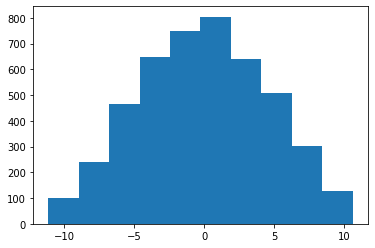

In [4]:
# TotalFrame[TotalFrame['zsmall_PC1deltabins']==11].zPC1, TotalFrame[TotalFrame['zsmall_PC1deltabins']==11].PC1
# TotalFrame.zPC1.sort_values(), TotalFrame.PC1.sort_values()
# type(TotalFrame['zsmall_PC1deltabins'][2])
# PC1bins
# TotalFrame.PC1.sort_values()
plt.hist(TotalFrame.PC1)

In [12]:
genes = ['CORO1A','FMNL1','sgControl']
for g in genes:
    num = TotalFrame[TotalFrame.Gene == g]
    print(f'There are {len(num)} images of genotype {g}')
    cellist = [x.split('frame')[0] for x in num.index]
    print(f'There are {len(pd.Series(cellist).unique())} cells of genotype {g}')


There are 358 images of genotype CORO1A
There are 27 cells of genotype CORO1A
There are 252 images of genotype FMNL1
There are 19 cells of genotype FMNL1
There are 310 images of genotype sgControl
There are 28 cells of genotype sgControl


In [4]:
############### Get Correlation matrix #######################

#stats to remove, if any
to_remove = [i for i in TotalFrame.columns.to_list() if 'Axis' in i] 
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'Centroid' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'bin' in i])
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'intensity' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'shcoeff' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'Trajectory' in i])
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'dist' in i])


#get pearson correlation matrix for TotalFrame without bins
totalcorr = TotalFrame.drop(columns = to_remove)
totalcorr = totalcorr.corr()


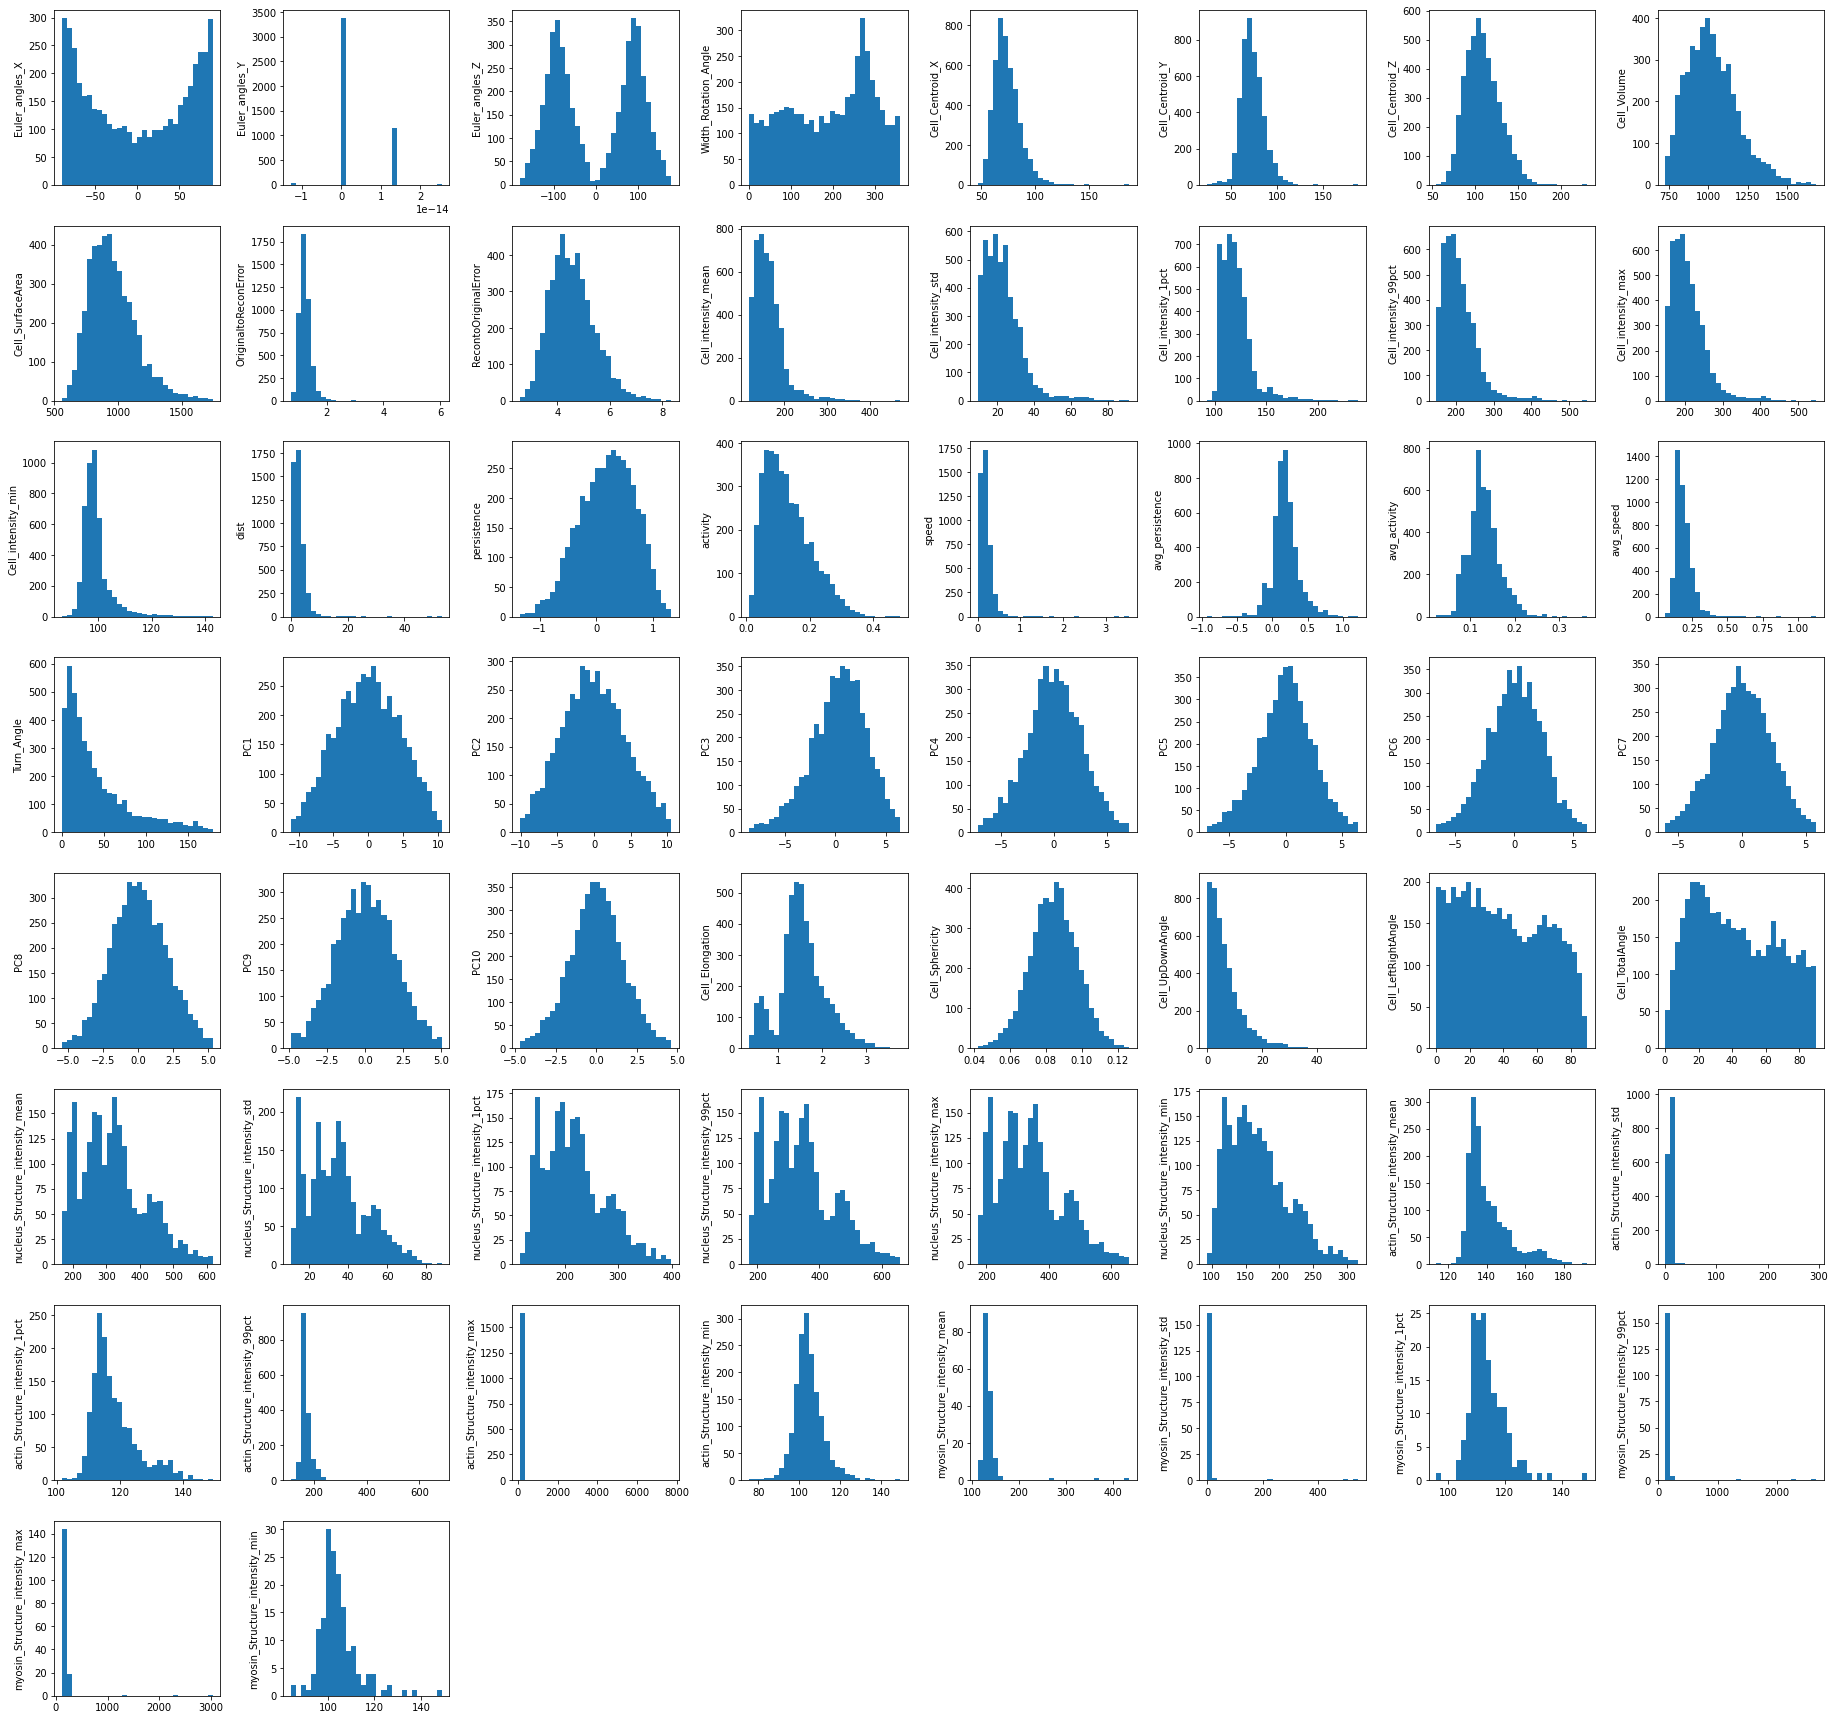

In [7]:
################# LOOK AT STAT DISTRIBUTIONS ######################


# colors = list(sns.color_palette('deep').as_hex())
smallerframe = TotalFrame.drop(columns = to_remove)
smallerframe = smallerframe.drop(columns = ['cell','cell.1','CellID','structure','frame'])
CoRo = math.ceil(math.sqrt(len(smallerframe.columns)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.2*CoRo,3*CoRo))#, sharex=True)

for i, met in enumerate(smallerframe.columns.to_list()):
    ax = axes[row,(i-((CoRo-1)*row)-row)]
    ax.hist(smallerframe.iloc[:,i], 30)#, color=colors[i]) , 30, (-2,2))
    ax.set_ylabel(smallerframe.iloc[:,i].name)#, fontsize = 1.75*CoRo)
    if (i+1)%(CoRo) ==0:
        row = row + 1

        
#delete all of the subplots that are unused
for a in range(i,CoRo**2):
    fig.delaxes(axes[row,(a-((CoRo-1)*row)-row)])
    if (a+1)%(CoRo) ==0:
        row = row + 1

# #     ax.set_ylabel(Nucleus_Metrics.iloc[:,i].name)

# # axes[0,0].set_title("Cell", fontsize = 16)
# # axes[0,1].set_title("Nucleus", fontsize = 16)
# # [ax.set_xlabel("Component value") for ax in axes[-1,:]];

plt.tight_layout()
plt.savefig(folder_fl + 'Shape Metric Histograms.png', bbox_inches='tight')

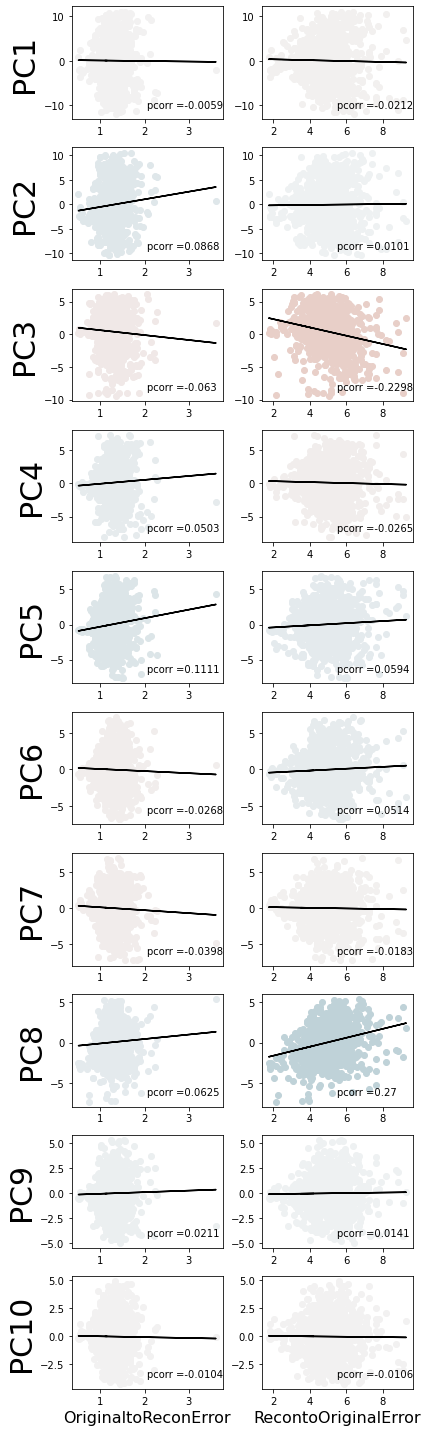

In [307]:

color_scale = pd.DataFrame({'color':list(sns.diverging_palette(20, 220, n=200).as_hex()),
              'value':list(np.arange(-1,1,2/200))})
#Scatter plots for cell metrics and the PCs
metric_frame = TotalFrame.loc[:,[x for x in list(TotalFrame.columns) if 'Error' in x]]
PC_frame = TotalFrame.loc[:,[x for x in list(TotalFrame.columns) if 'PC' in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'bin' not in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'delta' not in x]]

fig, axes = plt.subplots(len(PC_frame.columns), len(metric_frame.columns), figsize=(6,20))#, sharex=True)
for q in range(axes.shape[0]):
    for i, ax in enumerate(axes[q,:]):
        x = metric_frame.iloc[:,i]
        y = PC_frame[f'PC{q+1}']
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
        p_corr = totalcorr.loc[f'PC{q+1}', metric_frame.iloc[:,i].name]
        color = color_scale.color.loc[color_scale.value == closest(list(color_scale.value), p_corr)].values[0]
        ax.scatter(x,y, color = color)
        ax.plot(x, intercept+slope*x, 'k')
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
        ax.text(0.5, 0.1, 'pcorr ='+str(round(p_corr,4)),transform=ax.transAxes)




# metric_names = [Shape_Metrics.Cell_Volume.name, 
#                RelativeVectors.Y.name, RelativeVectors.Z.name, 
#                'Y+Z', 
#                RandomRotations.Wide_Variance.name,
#                RelativeAngles.PitchAngle.name,
#                RelativeAngles.RollAngle.name,
#                RelativeAngles.PitchAngleNorm.name,
#               RelativeAngles.RollAngleNorm.name#,
# #                Shape_Metrics.Tilt.name
#                ]

# axes[0,0].set_title("PC 1")
# axes[0,1].set_title("PC 2")
# axes[0,2].set_title("PC 3")
xlabels = [x.replace('_','\n') for x in metric_frame.columns]
[ax.set_ylabel(PC_frame.columns[i], fontsize = 30) for i, ax in enumerate(axes[:,0])];
[ax.set_xlabel(xlabels[i], fontsize = 16) for i, ax in enumerate(axes[-1,:])];

plt.tight_layout()
# plt.savefig(folder_fl+ 'PC vs. Metric scatter matrix.png', bbox_inches='tight')

In [20]:
# get list of metrics that are significant by anova
ModeFrame = TotalFrame.copy()

import scipy.stats as ss
siglist = []
new_remove = to_remove.copy()
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'cell' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'dist' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'activity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'structure' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'ID' in x])


for c in ModeFrame.drop(columns=new_remove).columns.to_list()[:-1]:
    samples = [g[1].dropna() for g in ModeFrame.groupby('Migration_Mode')[c]]
    f_val, p_val = ss.ttest_ind(*samples)
    print(f'Name: {c}, F value: {f_val}, p value: {p_val}')
    if p_val < 0.05:
        siglist.append(c) 
siglist = sorted(siglist)
# from statsmodels.stats.multicomp import pairwise_tukeyhsd
# for c in siglist:
#     print(f'Name {c}', pairwise_tukeyhsd(GeneFrame[c], GeneFrame['Gene']))
siglist
# units= ['(a.u.)','(a.u.)','(µm$^3$)','(a.u.)','(a.u.)','(µm$^2$)','(µm$^3$)',
#         '(a.u.)','(a.u.)']

Name: Width_Rotation_Angle, F value: 3.790258109573758, p value: 0.00015242457490195543
Name: Cell_Centroid_X, F value: -6.309601562324211, p value: 3.061793925379071e-10
Name: Cell_Centroid_Y, F value: -7.098699301682578, p value: 1.4529117855441205e-12
Name: Cell_Centroid_Z, F value: -2.6500181557977096, p value: 0.008076399558259199
Name: Cell_Volume, F value: -9.60611051202678, p value: 1.2034937659340833e-21
Name: Cell_SurfaceArea, F value: -0.1834625444982442, p value: 0.8544432227186024
Name: OriginaltoReconError, F value: -0.040235670578208364, p value: 0.9679069926095039
Name: RecontoOriginalError, F value: -6.356598392391943, p value: 2.2635228701103654e-10
Name: Cell_intensity_mean, F value: -7.341375117776133, p value: 2.4885139880033077e-13
Name: Cell_intensity_std, F value: -6.224340386504066, p value: 5.268051226155136e-10
Name: Cell_intensity_1pct, F value: -7.696757232753399, p value: 1.698186424065237e-14
Name: Cell_intensity_99pct, F value: -7.212749767243652, p valu

['Cell_Centroid_X',
 'Cell_Centroid_Y',
 'Cell_Centroid_Z',
 'Cell_Sphericity',
 'Cell_Volume',
 'Cell_intensity_1pct',
 'Cell_intensity_99pct',
 'Cell_intensity_max',
 'Cell_intensity_mean',
 'Cell_intensity_min',
 'Cell_intensity_std',
 'PC1',
 'PC6',
 'PC7',
 'PC8',
 'RecontoOriginalError',
 'Turn_Angle',
 'Width_Rotation_Angle',
 'actin_Structure_intensity_1pct',
 'actin_Structure_intensity_99pct',
 'actin_Structure_intensity_mean',
 'myosin_Structure_intensity_1pct',
 'myosin_Structure_intensity_std',
 'nucleus_Structure_intensity_99pct',
 'nucleus_Structure_intensity_max',
 'nucleus_Structure_intensity_std',
 'persistence',
 'speed']

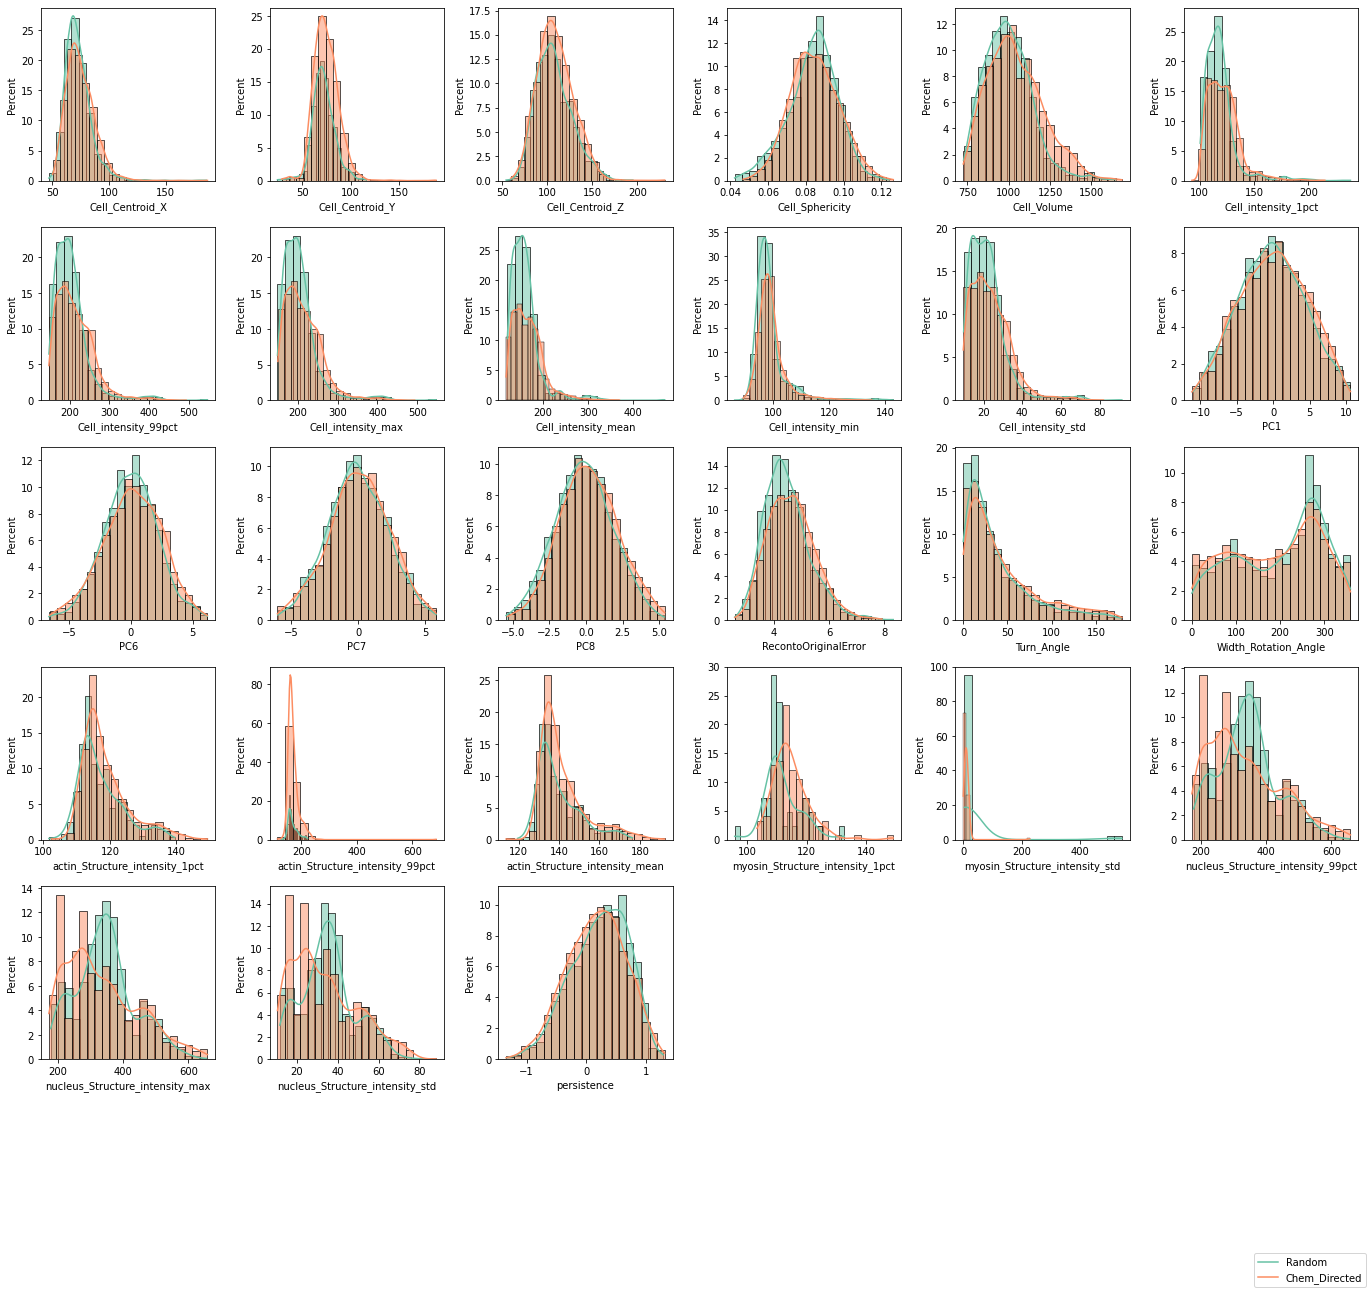

In [35]:
################# LOOK AT STAT DISTRIBUTIONS OF SIGNIFICANT STATS ######################
import seaborn as sns

colors = sns.color_palette("Set2")
colors = list(colors.as_hex())


# colors = list(sns.color_palette('deep').as_hex())
smallerframe = TotalFrame[siglist]
CoRo = math.ceil(math.sqrt(len(smallerframe.columns)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.2*CoRo,3*CoRo))#, sharex=True)

for i, met in enumerate(smallerframe.columns.to_list()):
    samples = [g[1].dropna() for g in ModeFrame.groupby('Migration_Mode')[met]]
    ax = axes[row,(i-((CoRo-1)*row)-row)]
    sns.histplot(ax = ax, data=samples[0], bins=21, stat='percent', color = colors[0], kde = True)
    sns.histplot(ax = ax, data=samples[1], bins=21, stat='percent', color = colors[1], kde = True)
#     ax.set_ylabel(met)#, fontsize = 1.75*CoRo)
    if (i+1)%(CoRo) ==0:
        row = row + 1


ax = axes[row,(i-((CoRo-1)*row)-row)]
fig.legend(ModeFrame.Migration_Mode.unique(), loc = 'lower right')

#delete all of the subplots that are unused
for a in range(i,CoRo**2):
    fig.delaxes(axes[row,(a-((CoRo-1)*row)-row)])
    if (a+1)%(CoRo) ==0:
        row = row + 1

# #     ax.set_ylabel(Nucleus_Metrics.iloc[:,i].name)

# # axes[0,0].set_title("Cell", fontsize = 16)
# # axes[0,1].set_title("Nucleus", fontsize = 16)
# # [ax.set_xlabel("Component value") for ax in axes[-1,:]];
# plt.legend(ModeFrame.Migration_Mode.unique(), loc ='lower right')
plt.tight_layout()
plt.savefig(folder_fl + 'Significant Shape Metric Histograms.png', bbox_inches='tight')

C:\Users\Aaron\anaconda3\envs\shape\lib\site-packages\ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator


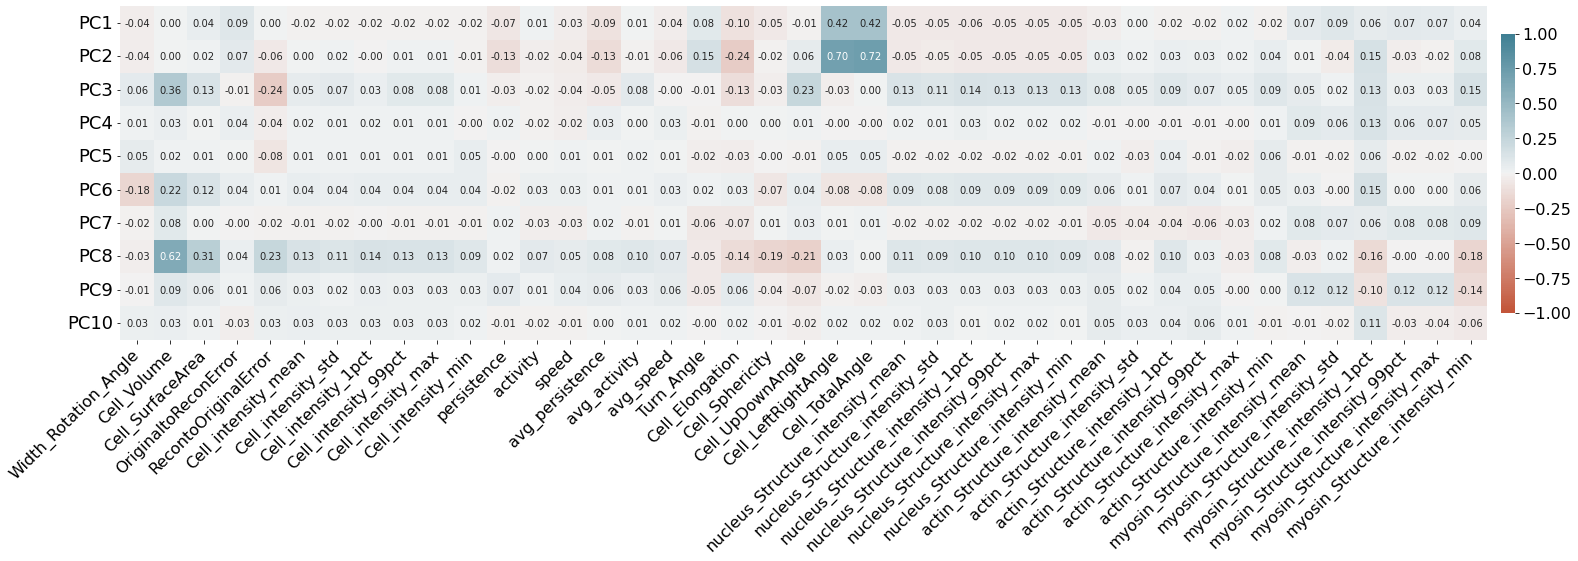

In [26]:
#correlations of shapes with PCs (PCs as rows)

coldrop = []
coldrop.extend([x for x in totalcorr.columns.to_list() if 'delta' in x])
coldrop.extend([x for x in totalcorr.columns.to_list() if 'PC' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Euler' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Centroid' in x])
coldrop.extend(['frame','dist'])

PCsAndMetrics = totalcorr.loc[[x for x in totalcorr.index if 'PC' in x and 'delta' not in x]]
PCsAndMetrics = PCsAndMetrics.drop(columns = coldrop)
fig, ax = plt.subplots(figsize=(25,15))
ax = sns.heatmap(
    PCsAndMetrics, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    annot = True,
    fmt = '.2f',
    cbar_kws={'fraction':0.01, 'pad':0.01}#, 'shrink': 0.5}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize = 16
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    va = 'center',
    fontsize = 18
)
#scooch the x axis labels by a certain amount
dx = 6/72.; dy = 0/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)

plt.savefig(folder_fl + 'PC correlation with shape metrics heatmap.png', bbox_inches='tight')

In [19]:
len(PCsAndMetrics.columns)

48

C:\Users\Aaron\anaconda3\envs\shape\lib\site-packages\ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


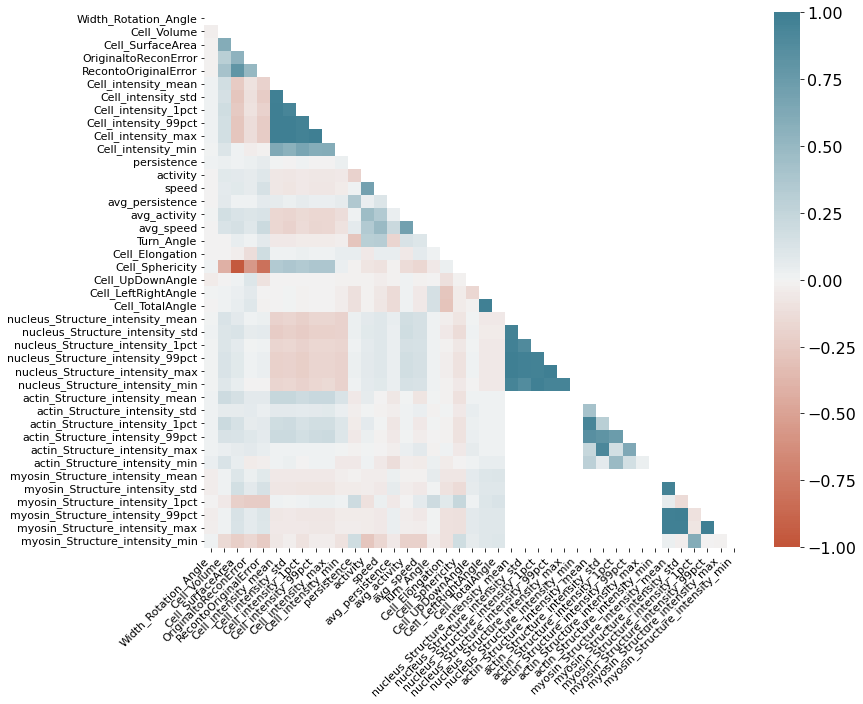

In [28]:
#get columns with nucleus and rows with cells from correlation matrix
coldrop = []
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Euler' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Centroid' in x])
coldrop.extend(['frame','dist'])

PartFramecorr = TotalFrame.drop(columns = to_remove)
PartFramecorr = PartFramecorr.drop(columns = coldrop)
PartFramecorr = PartFramecorr.drop(columns = ([i for i in PartFramecorr.columns.to_list() if 'PC' in i]))
PartFramecorr = PartFramecorr.drop(columns = ([x for x in PartFramecorr.columns.to_list() if 'delta' in x]))
PartFramecorr = PartFramecorr.corr()

#comparison of CELL features
mask = np.zeros_like(PartFramecorr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(
    PartFramecorr,
    mask = mask,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize = 11
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize = 11
)
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
figsize = (5, 30)
plt.savefig(folder_fl + ' Shape Metric corr.png', bbox_inches='tight')

C:\Users\Aaron\anaconda3\envs\shape\lib\site-packages\ipykernel_launcher.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator


[Text(1, -1.0, '−1.00'),
 Text(1, -0.75, '−0.75'),
 Text(1, -0.5, '−0.50'),
 Text(1, -0.25, '−0.25'),
 Text(1, 0.0, '0.00'),
 Text(1, 0.25, '0.25'),
 Text(1, 0.5, '0.50'),
 Text(1, 0.75, '0.75'),
 Text(1, 1.0, '1.00')]

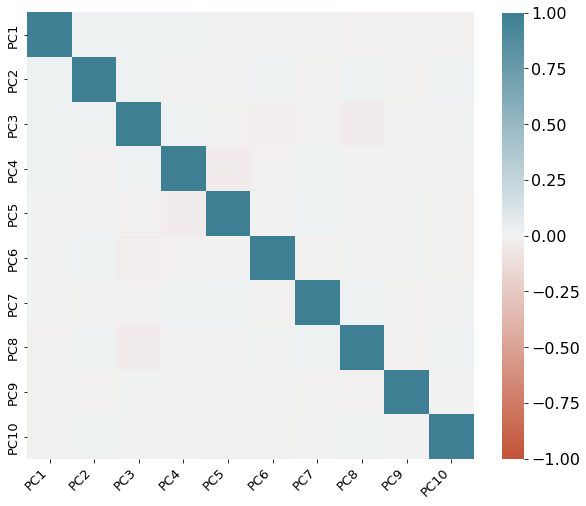

In [29]:
########################## PC Correlations #################

PCcorr = totalcorr.loc[[x for x in list(totalcorr.columns) if 'PC' in x]].loc[:,[x for x in list(totalcorr.columns) if 'PC' in x]]



#comparison of CELL features
fig, ax = plt.subplots(figsize=(len(PCcorr),len(PCcorr)))
ax = sns.heatmap(
    PCcorr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize = 13
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize = 13
)
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)

# plt.savefig(folder_fl + 'Cell+Nuc Shape Metric corr rotationally aligned.png', bbox_inches='tight')

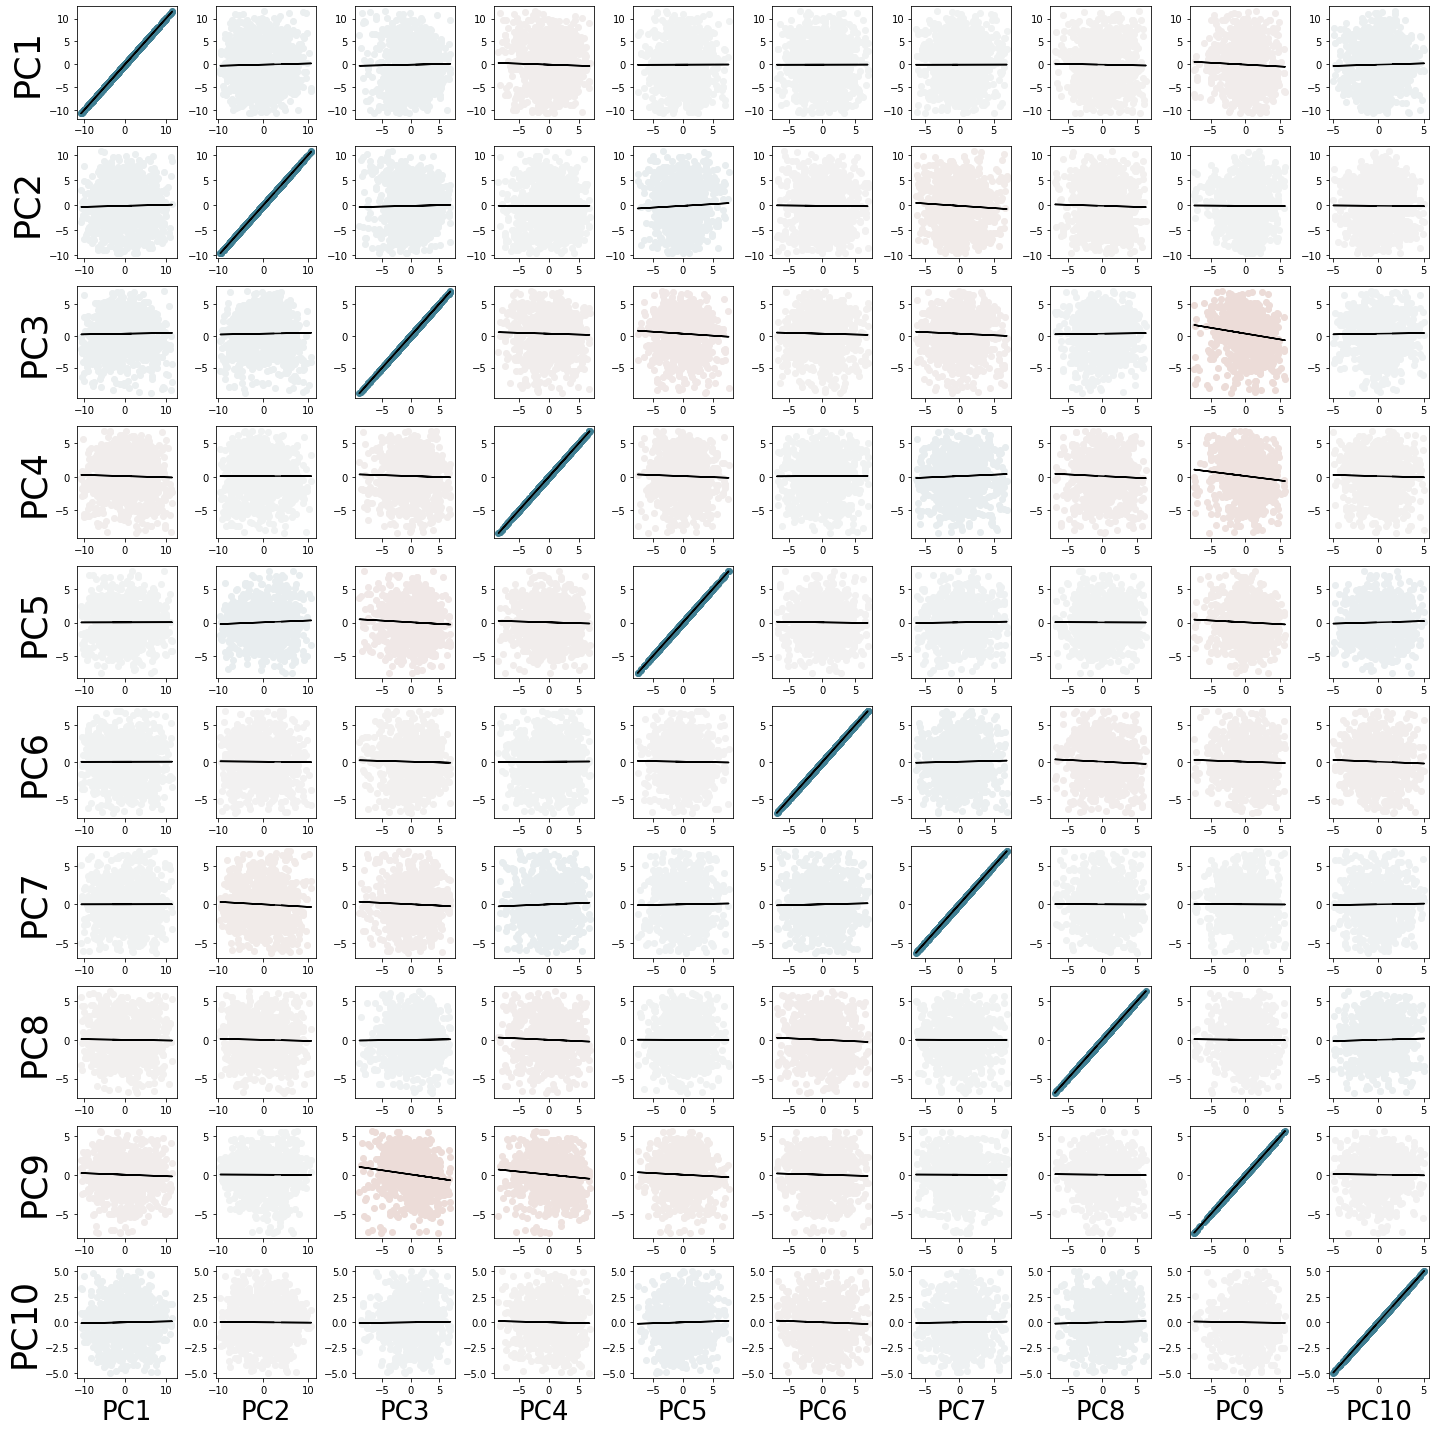

In [15]:
##################### look at scatter correlations between all PCs ###################

def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(20, 220, n=200).as_hex()),
              'value':list(np.arange(-1,1,2/200))})
#Scatter plots for cell metrics and the PCs
PC_frame = TotalFrame.loc[:,[x for x in list(TotalFrame.columns) if 'PC' in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'bin' not in x]]

fig, axes = plt.subplots(len(PC_frame.columns), len(PC_frame.columns), figsize=(20,20))#, sharex=True)
for q in range(axes.shape[0]):
    for i, ax in enumerate(axes[q,:]):
        x = PC_frame[f'PC{i+1}']
        y = PC_frame[f'PC{q+1}']
        coef = np.polyfit(x,y,1)
        poly1d_fn = np.poly1d(coef) 
        p_corr = totalcorr.loc[f'PC{q+1}', f'PC{i+1}']
        color = color_scale.color.loc[color_scale.value == closest(list(color_scale.value), p_corr)].values[0]
        ax.scatter(x,y, color = color)
        ax.plot(x, poly1d_fn(x), 'k')




# metric_names = [Shape_Metrics.Cell_Volume.name, 
#                RelativeVectors.Y.name, RelativeVectors.Z.name, 
#                'Y+Z', 
#                RandomRotations.Wide_Variance.name,
#                RelativeAngles.PitchAngle.name,
#                RelativeAngles.RollAngle.name,
#                RelativeAngles.PitchAngleNorm.name,
#               RelativeAngles.RollAngleNorm.name#,
# #                Shape_Metrics.Tilt.name
#                ]

# axes[0,0].set_title("PC 1")
# axes[0,1].set_title("PC 2")
# axes[0,2].set_title("PC 3")
xlabels = PC_frame.columns
[ax.set_ylabel(PC_frame.columns[i], fontsize = 35) for i, ax in enumerate(axes[:,0])];
[ax.set_xlabel(xlabels[i], fontsize = 26) for i, ax in enumerate(axes[-1,:])];

plt.tight_layout()
# plt.savefig(folder_fl+ 'PC vs. Metric scatter matrix.png', bbox_inches='tight')

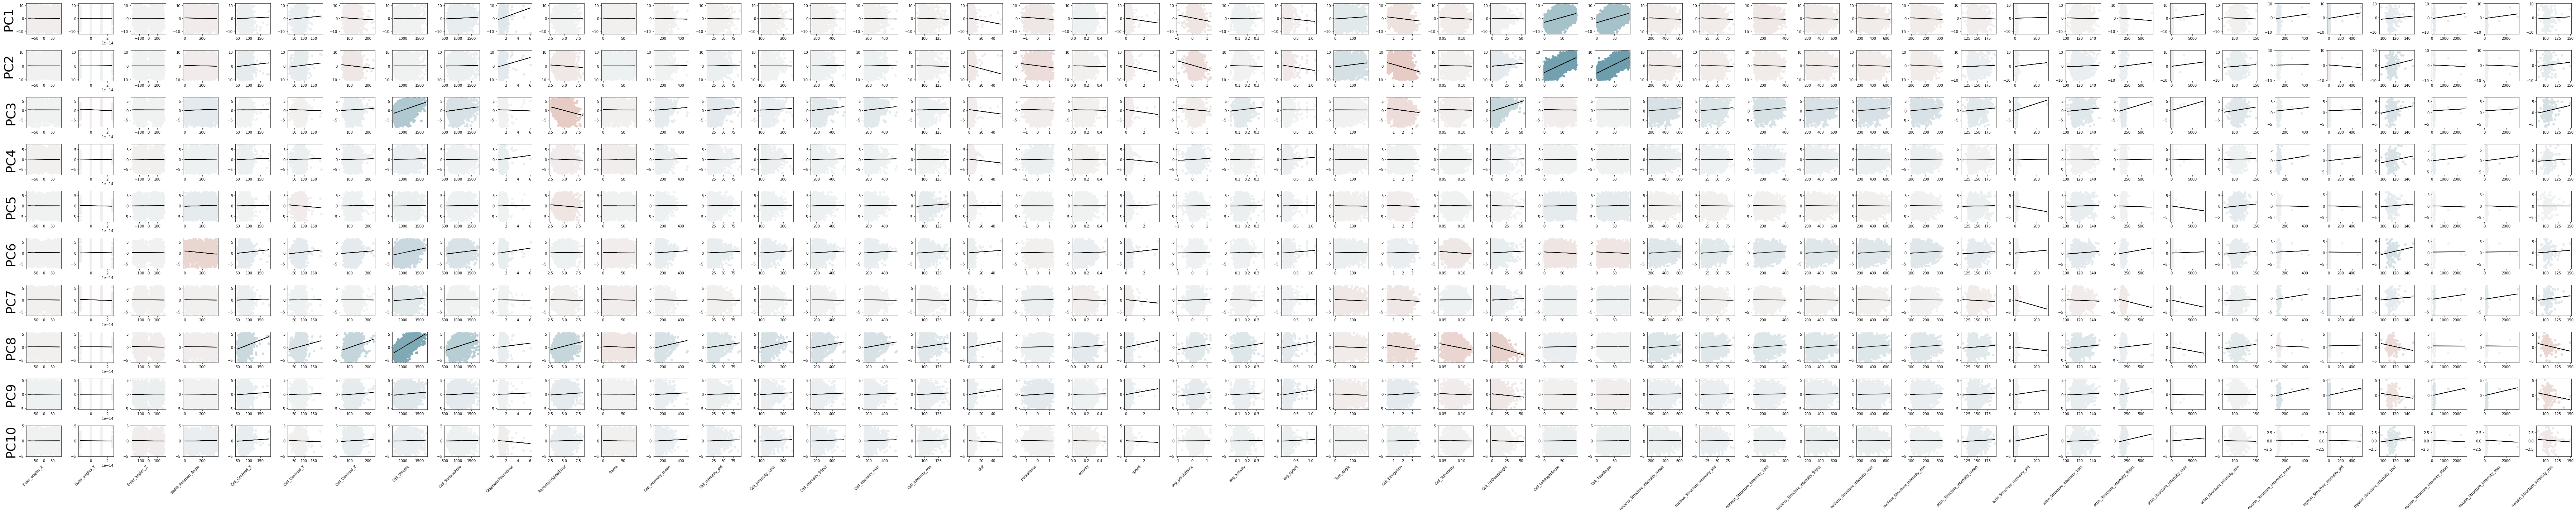

In [8]:
def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(20, 220, n=200).as_hex()),
              'value':list(np.arange(-1,1,2/200))})
#Scatter plots for cell metrics and the PCs
#stats to remove, if any
coldrop = [i for i in TotalFrame.columns.to_list() if 'PC' in i] 
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'bin' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'cell' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'CellID' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'structure' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'Migration' in i])
coldrop.extend(to_remove)
# metric_frame = metric_frame.drop(columns=list(set(metric_frame.columns.to_list()).intersection(to_remove)))
metric_frame = TotalFrame.drop(columns=coldrop)

PC_frame = TotalFrame.loc[:,[x for x in list(TotalFrame.columns) if 'PC' in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'bin' not in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'delta' not in x]]

cols = metric_frame.columns.to_list()
fig, axes = plt.subplots(len(PC_frame.columns), len(metric_frame.columns), figsize=(100,20))#, sharex=True)
for q in range(axes.shape[0]):
    for i, ax in enumerate(axes[q,:]):
        rows = metric_frame.iloc[:,i][metric_frame.iloc[:,i].isna() == False].index.to_list()
        x = metric_frame.loc[rows,cols[i]]
        y = PC_frame.loc[rows,f'PC{q+1}']
        coef = np.polyfit(x,y,1)
        poly1d_fn = np.poly1d(coef) 
        p_corr = totalcorr.loc[f'PC{q+1}', metric_frame.iloc[:,i].name]
        color = color_scale.color.loc[color_scale.value == closest(list(color_scale.value), p_corr)].values[0]
        ax.scatter(x,y, color = color)
        ax.plot(x, poly1d_fn(x), 'k')
#         ax.text(0.1,0.1,str(np.around(p_corr, decimals=2)))



# metric_names = [Shape_Metrics.Cell_Volume.name, 
#                RelativeVectors.Y.name, RelativeVectors.Z.name, 
#                'Y+Z', 
#                RandomRotations.Wide_Variance.name,
#                RelativeAngles.PitchAngle.name,
#                RelativeAngles.RollAngle.name,
#                RelativeAngles.PitchAngleNorm.name,
#               RelativeAngles.RollAngleNorm.name#,
# #                Shape_Metrics.Tilt.name
#                ]

# axes[0,0].set_title("PC 1")
# axes[0,1].set_title("PC 2")
# axes[0,2].set_title("PC 3")
# xlabels = [x.replace('_','\n') for x in metric_frame.columns]
[ax.set_ylabel(PC_frame.columns[i], fontsize = 35) for i, ax in enumerate(axes[:,0])];
[ax.set_xlabel(metric_frame.columns[i], rotation=45, horizontalalignment='right', fontsize = 10) for i, ax in enumerate(axes[-1,:])];

plt.tight_layout()
plt.savefig(folder_fl+ 'PC vs. Metric scatter matrix.png', bbox_inches='tight')

In [359]:
# coldrop = [i for i in TotalFrame.columns.to_list() if 'PC' in i] 
# coldrop.extend([i for i in TotalFrame.columns.to_list() if 'bin' in i])
# coldrop.extend([i for i in TotalFrame.columns.to_list() if 'cell' in i])
# coldrop.extend([i for i in TotalFrame.columns.to_list() if 'CellID' in i])
# coldrop.extend([i for i in TotalFrame.columns.to_list() if 'delta' in i])
# coldrop, list(set(coldrop).intersection(to_remove))
# metric_frame = metric_frame.drop(columns=list(set(metric_frame.columns.to_list()).intersection(to_remove)))
# metric_frame.columns.to_list()
str(np.around(p_corr, decimals=2))

'-0.0'

In [6]:
metric_frame.columns

Index(['Euler_angles_X', 'Euler_angles_Y', 'Euler_angles_Z',
       'Width_Rotation_Angle', 'Cell_Centroid_X', 'Cell_Centroid_Y',
       'Cell_Centroid_Z', 'Cell_Volume', 'Cell_SurfaceArea',
       'OriginaltoReconError', 'RecontoOriginalError', 'frame',
       'Cell_intensity_mean', 'Cell_intensity_std', 'Cell_intensity_1pct',
       'Cell_intensity_99pct', 'Cell_intensity_max', 'Cell_intensity_min',
       'dist', 'persistence', 'activity', 'speed', 'avg_persistence',
       'avg_activity', 'avg_speed', 'Turn_Angle', 'Cell_Elongation',
       'Cell_Sphericity', 'Cell_UpDownAngle', 'Cell_LeftRightAngle',
       'Cell_TotalAngle', 'nucleus_Structure_intensity_mean',
       'nucleus_Structure_intensity_std', 'nucleus_Structure_intensity_1pct',
       'nucleus_Structure_intensity_99pct', 'nucleus_Structure_intensity_max',
       'nucleus_Structure_intensity_min', 'actin_Structure_intensity_mean',
       'actin_Structure_intensity_std', 'actin_Structure_intensity_1pct',
       'actin_Stru